# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
!echo $CONDA_PREFIX

/home/wassim/anaconda3/envs/PhySO


In [2]:
# External packages
import torch
import numpy as np

# Pyplot
%matplotlib inline
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

/home/wassim/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [4]:
torch.cuda.is_available()

False

## Test case

In [5]:
data_size = int(1e3)

In [6]:
# Data points
c = 10.
data_lowbound, data_upbound = -10, 10
m = np.random.uniform(data_lowbound, data_upbound, data_size)
data_lowbound, data_upbound = -0.9*c, 0.9*c
v = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = m
x1_array = v
X_array = np.stack((x0_array, x1_array), axis=0)
y_array = m*(c**2)*(1/(1-((v**2)/(c**2)))**0.5)

# One of many symbolic solutions:
target_program_str = ["mul", "mul", "m", "n2", "c", "inv", "sqrt", "sub", "1", "div", "n2", "v", "n2", "c",]
print(len(target_program_str))


14


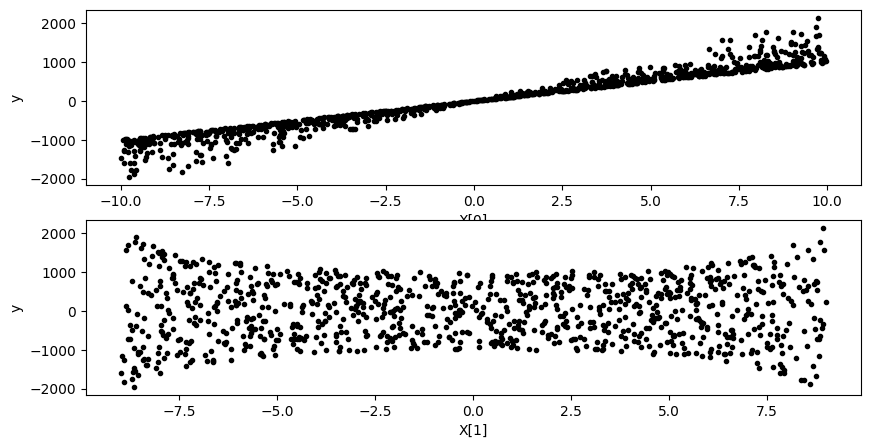

In [7]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [8]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.) .astype(float)).to(DEVICE)
c      = torch.tensor(np.array(c)  .astype(float)).to(DEVICE)

## Run config

### Library config

In [9]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"m" : 0         , "v" : 1         ,},
                "input_var_units"      : {"m" : [0, 0, 1] , "v" : [1, -1, 0] ,},
                "input_var_complexity" : {"m" : 1.        , "v" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , "c" : c          },
                "constants_units"      : {"1" : [0, 0, 0] , "c" : [1, -1, 0] },
                "constants_complexity" : {"1" : 1.        , "c" : 1.         },
                # free constants
                #"free_constants"            : {"c"              },
                #"free_constants_init_val"   : {"c" : 1.         },
                #"free_constants_units"      : {"c" : [1, -1, 0] },
                #"free_constants_complexity" : {"c" : 1.         },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                "superparent_units" : [2, -2, 1],
                "superparent_name"  : "E",
                }

### Free constant optimizer config

In [10]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Learning config

In [11]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [12]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [13]:
learning_config = {
    # Batch related
    'batch_size'      : BATCH_SIZE,
    'max_time_step'   : MAX_LENGTH,
    'n_epochs'        : int(1e9), # int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'     : 0.7,
    'entropy_weight'  : 0.03,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'   : GET_OPTIMIZER,
}

### Priors config

In [14]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [15]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
}

### Logger

In [16]:
save_path_training_curves = 'RelatE_curves.png'
save_path_log             = 'RelatE.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 20,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [17]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

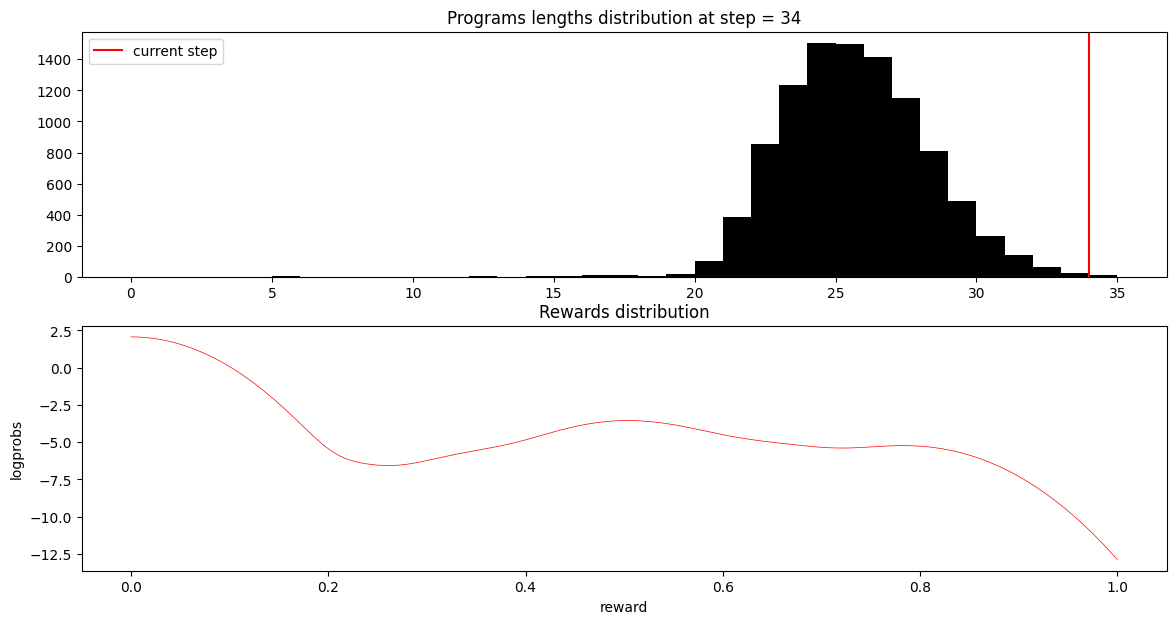

In [18]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


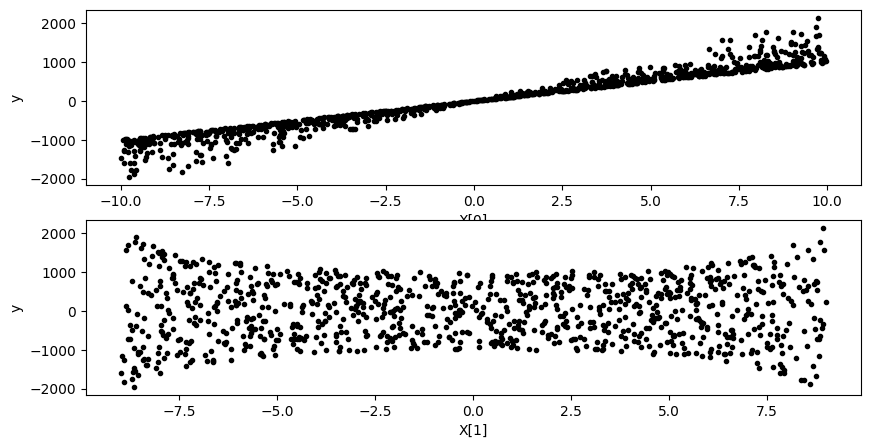

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'c': 12, 'm': 13, 'v': 14}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 c m v E dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([2, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy'

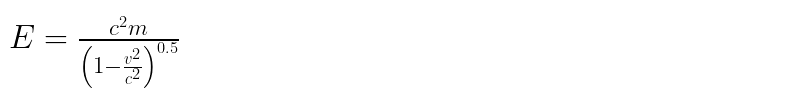

Simplified expression:


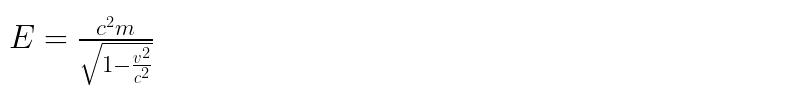

Ideal reward : 1.0


In [19]:
target_program = benchmark.sanity_check(X, y, run_config, target_program_str=target_program_str)

## Run

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 14.14 s

Overall best  at R=0.817156
-> Raw expression : 
            2          
           c           
───────────────────────
⎛          1          ⎞
⎜─────────────────────⎟
⎜     ⎛      1       ⎞⎟
⎜m⋅log⎜──────────────⎟⎟
⎜     ⎜        2     ⎟⎟
⎝     ⎝-1 + sin (1)⋅1⎠⎠

Best of epoch at R=0.817156
-> Raw expression : 
            2          
           c           
───────────────────────
⎛          1          ⎞
⎜─────────────────────⎟
⎜     ⎛      1       ⎞⎟
⎜m⋅log⎜──────────────⎟⎟
⎜     ⎜        2     ⎟⎟
⎝     ⎝-1 + sin (1)⋅1⎠⎠


=========== Epoch 00001 ===========
-> Time 9.25 s

Overall best  at R=0.817156
-> Raw expression : 
            2          
           c           
───────────────────────
⎛          1          ⎞
⎜─────────────────────⎟
⎜     ⎛      1       ⎞⎟
⎜m⋅log⎜──────────────⎟⎟
⎜     ⎜        2     ⎟⎟
⎝     ⎝-1 + sin (1)⋅1⎠⎠

Best of epoch at R=0.781607
-> Raw expression : 
         2⎛   ⎛1⎞⎞  
      log ⎜sin⎜─⎟⎟  
   2 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00040 ===========
-> Time 22.88 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
          1      
1⋅c⋅─────────────
    ⎛      ⎛1⎞  ⎞
    ⎜   sin⎜─⎟  ⎟
    ⎜      ⎝1⎠  ⎟
    ⎜───────────⎟
    ⎜⎛    1    ⎞⎟
    ⎜⎜─────────⎟⎟
    ⎜⎜⎛   c   ⎞⎟⎟
    ⎜⎜⎜───────⎟⎟⎟
    ⎜⎜⎜⎛  c  ⎞⎟⎟⎟
    ⎜⎜⎜⎜─────⎟⎟⎟⎟
    ⎜⎜⎜⎜⎛ 1 ⎞⎟⎟⎟⎟
    ⎜⎜⎜⎜⎜───⎟⎟⎟⎟⎟
    ⎝⎝⎝⎝⎝c⋅m⎠⎠⎠⎠⎠


=========== Epoch 00041 ===========
-> Time 7.87 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814882
-> Raw expression : 
    ⎛   ⎛c⎞    ⎞    ⎛1⎞
c⋅c⋅⎜cos⎜─⎟ + 1⎟⋅sin⎜─⎟
    ⎝   ⎝c⎠    ⎠    ⎝1⎠
───────────────────────
          ⎛1⎞          
          ⎜─⎟          
          ⎝m⎠          


=========== Epoch 00042 ===========
-> Time 8.16 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00060 ===========
-> Time 23.04 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
       c        
────────────────
      1         
1⋅1⋅─────⋅sin(1)
    1⋅c⋅m       


=========== Epoch 00061 ===========
-> Time 8.16 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.816204
-> Raw expression : 
         m         
───────────────────
                  2
⎛   ⎛     1     ⎞⎞ 
⎜   ⎜1⋅c⋅─── + m⎟⎟ 
⎜   ⎜    ⎛c⎞    ⎟⎟ 
⎜   ⎜    ⎜─⎟    ⎟⎟ 
⎜   ⎜    ⎝m⎠    ⎟⎟ 
⎜sin⎜───────────⎟⎟ 
⎜   ⎝     m     ⎠⎟ 
⎜────────────────⎟ 
⎝       c        ⎠ 


=========== Epoch 00062 ===========
-> Time 7.99 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817238
-> Raw expression : 
    c⋅cos(1)   
───────────────
⎛      1      ⎞
⎜──────

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00080 ===========
-> Time 22.09 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
          m          
─────────────────────
       ⎛1⎞     1     
1⋅1⋅sin⎜─⎟⋅──────────
       ⎝1⎠          2
           ⎛   1   ⎞ 
           ⎜───────⎟ 
           ⎜     1 ⎟ 
           ⎜c⋅1⋅───⎟ 
           ⎝    c⋅c⎠ 


=========== Epoch 00081 ===========
-> Time 7.84 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
     2    
    c     
──────────
⎛sin(1⋅1)⎞
⎜────────⎟
⎝   m    ⎠


=========== Epoch 00082 ===========
-> Time 10.06 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
    c⋅m     
────────────
⎛   ⎛  1  ⎞⎞
⎜sin⎜1⋅─⋅c⎟⎟
⎜   ⎝  c  ⎠⎟
⎜──────────⎟
⎝   1⋅c    ⎠




/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00100 ===========
-> Time 21.76 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
           1            
────────────────────────
   1       0.5⎛1⎞    ⎛1⎞
───────⋅sin   ⎜─⎟⋅sin⎜─⎟
⎛  c  ⎞       ⎝1⎠    ⎝1⎠
⎜─────⎟                 
⎜   1 ⎟                 
⎜1⋅───⎟                 
⎝  c⋅m⎠                 


=========== Epoch 00101 ===========
-> Time 7.80 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.897764
-> Raw expression : 
          c           
──────────────────────
   ⎛      1⎞      1   
cos⎜v⋅1⋅1⋅─⎟⋅1⋅───────
   ⎝      c⎠       1  
               1⋅─────
                 ⎛ 1 ⎞
                 ⎜───⎟
                 ⎝c⋅m⎠


=========== Epoch 00102 ===========
-> Time 8.05 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00120 ===========
-> Time 22.19 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817255
-> Raw expression : 
⎛   ⎛ 1⎞      ⎛1⎞⎞ 1        
⎜sin⎝ℯ ⎠ + sin⎜─⎟⎟⋅─⋅1⋅m⋅c⋅c
⎝             ⎝1⎠⎠ 1        


=========== Epoch 00121 ===========
-> Time 7.75 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
         m          
────────────────────
   ⎛  1  ⎞ 1      1 
sin⎜─────⎟⋅─⋅1⋅m⋅───
   ⎜  1  ⎟ c     c⋅m
   ⎜c⋅─⋅1⎟          
   ⎝  c  ⎠          


=========== Epoch 00122 ===========
-> Time 8.43 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
          m           
──────────────────────
⎛         m          ⎞
⎜────────────────────⎟
⎜  1                 ⎟
⎜──────⋅1⋅1⋅1⋅c⋅1⋅c⋅m⎟
⎝sin(1) 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00140 ===========
-> Time 22.40 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.815749
-> Raw expression : 
                   2  
 ⎛               2⎞   
 ⎜⎛          ⎛c⎞⎞ ⎟   
 ⎜⎜sin(1)⋅sin⎜─⎟⎟ ⎟ ⋅1
 ⎝⎝          ⎝c⎠⎠ ⎠   
ℯ                     
──────────────────────
       ⎛  1  ⎞        
       ⎜─────⎟        
       ⎝c⋅c⋅m⎠        


=========== Epoch 00141 ===========
-> Time 7.72 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
            0.5
  ⎛  1     ⎞   
m⋅⎜──────⋅1⎟   
  ⎝sin(1)  ⎠   
───────────────
    ⎛sin(1)⎞   
    ⎜──────⎟   
    ⎝ c⋅c  ⎠   


=========== Epoch 00142 ===========
-> Time 7.96 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
         1        
c⋅c

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00160 ===========
-> Time 22.02 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
   c⋅c⋅c    
────────────
    1       
c⋅1⋅─⋅sin(1)
    m       


=========== Epoch 00161 ===========
-> Time 9.04 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.919116
-> Raw expression : 
                2     
   c           v      
─────── + ────────────
⎛  1  ⎞   ⎛    1     ⎞
⎜─────⎟   ⎜──────────⎟
⎝1⋅c⋅m⎠   ⎜⎛m⋅sin(1)⎞⎟
          ⎜⎜────────⎟⎟
          ⎜⎜  ⎛m⎞   ⎟⎟
          ⎜⎜  ⎜─⎟   ⎟⎟
          ⎝⎝  ⎝m⎠   ⎠⎠


=========== Epoch 00162 ===========
-> Time 8.50 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
         c          
────────────────────
⎛            0.5⎛1⎞⎞
⎜c⋅sin(1)⋅sin   ⎜─⎟⎟
⎜

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00180 ===========
-> Time 22.05 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.929742
-> Raw expression : 
  c          
───── + m⋅v⋅v
   1         
1⋅───        
  c⋅m        


=========== Epoch 00181 ===========
-> Time 8.46 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.915235
-> Raw expression : 
             2   
 2        m⋅v    
c ⋅m + ──────────
          ⎛  1  ⎞
       sin⎜─────⎟
          ⎜    1⎟
          ⎜c⋅1⋅─⎟
          ⎝    c⎠


=========== Epoch 00182 ===========
-> Time 8.10 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.929742
-> Raw expression : 
  ⎛ 0.5         ⎞
  ⎜1   ⋅c⋅c    2⎟
m⋅⎜──────── + v ⎟
  ⎜ 2   1       ⎟
  ⎜c ⋅─────     ⎟
  ⎜   ⎛ c ⎞     ⎟
  ⎜   ⎜───⎟     ⎟
  ⎜   ⎜  1⎟     ⎟
  ⎜   ⎜1⋅─⎟     ⎟
  ⎝ 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00200 ===========
-> Time 22.49 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
   c⋅m    
──────────
         1
sin(1)⋅1⋅─
         c


=========== Epoch 00201 ===========
-> Time 7.80 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.816064
-> Raw expression : 
          1   
   -1 + ──────
        sin(1)
m⋅ℯ           
──────────────
        1     
 m⋅1⋅───────  
     ⎛  m  ⎞  
     ⎜─────⎟  
     ⎜⎛ 1 ⎞⎟  
     ⎜⎜───⎟⎟  
     ⎝⎝c⋅c⎠⎠  


=========== Epoch 00202 ===========
-> Time 7.93 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.919116
-> Raw expression : 
             2    
            v     
c⋅c⋅m + ──────────
        ⎛   1    ⎞
        ⎜────────⎟
        ⎜⎛   ⎛1⎞⎞⎟
        ⎜⎜sin⎜─⎟⎟⎟
        ⎜⎜  

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00220 ===========
-> Time 22.74 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.890113
-> Raw expression : 
  ⎛          ⎛c⎞⎞
  ⎜     c⋅sin⎜─⎟⎟
  ⎜ 2        ⎝c⎠⎟
m⋅⎜v  + ────────⎟
  ⎜       ⎛1⎞   ⎟
  ⎜       ⎜─⎟   ⎟
  ⎝       ⎝c⎠   ⎠


=========== Epoch 00221 ===========
-> Time 7.78 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
          c           
──────────────────────
  1      0.5       ⎛1⎞
─────⋅sin   (1)⋅sin⎜─⎟
1⋅c⋅m              ⎝1⎠


=========== Epoch 00222 ===========
-> Time 8.00 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
                  0.5
        ⎛   1    ⎞   
c⋅c⋅c⋅m⋅⎜────────⎟   
        ⎜⎛   ⎛1⎞⎞⎟   
        ⎜⎜sin⎜─⎟⎟⎟   
        ⎜⎜   ⎝1⎠⎟⎟   
       

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00240 ===========
-> Time 22.01 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.837366
-> Raw expression : 
      ⎛          2         ⎞
      ⎜⎛v⋅sin(1)⎞          ⎟
c⋅c⋅m⋅⎜⎜────────⎟  + sin(1)⎟
      ⎝⎝   c    ⎠          ⎠


=========== Epoch 00241 ===========
-> Time 8.64 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
              c               
──────────────────────────────
   ⎛1⎞      1              0.5
sin⎜─⎟⋅1⋅───────⋅(1⋅sin(1))   
   ⎝1⎠   ⎛  1  ⎞              
         ⎜─────⎟              
         ⎜   1 ⎟              
         ⎜1⋅───⎟              
         ⎝  c⋅m⎠              


=========== Epoch 00242 ===========
-> Time 7.95 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817283
-> Raw

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00260 ===========
-> Time 21.51 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
     c⋅c⋅m      
────────────────
   0.5⎛1⎞       
sin   ⎜─⎟⋅sin(1)
      ⎝1⎠       


=========== Epoch 00261 ===========
-> Time 8.63 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814938
-> Raw expression : 
       c       
───────────────
⎛    sin(1)   ⎞
⎜─────────────⎟
⎜⎛        0.5⎞⎟
⎜⎜⎛  1   ⎞   ⎟⎟
⎜⎜⎜──────⎟   ⎟⎟
⎜⎜⎝sin(1)⎠   ⎟⎟
⎜⎜───────────⎟⎟
⎜⎜  ⎛  1  ⎞  ⎟⎟
⎜⎜  ⎜─────⎟  ⎟⎟
⎝⎝  ⎝1⋅c⋅m⎠  ⎠⎠


=========== Epoch 00262 ===========
-> Time 8.71 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.814483
-> Raw expression : 
       c        
────────────────
⎛      1       ⎞
⎜──────────────⎟
⎜          1   ⎟
⎜1⋅1⋅c⋅m⋅──────⎟
⎝

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00280 ===========
-> Time 22.91 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817292
-> Raw expression : 
              0.5
⎛         0.5⎞   
⎜⎛   1   ⎞   ⎟   
⎜⎜───────⎟   ⎟   
⎜⎜   ⎛ c⎞⎟   ⎟   
⎜⎜   ⎜ ─⎟⎟   ⎟   
⎜⎜   ⎜ c⎟⎟   ⎟   
⎝⎝sin⎝ℯ ⎠⎠   ⎠   
─────────────────
     ⎛  1  ⎞     
     ⎜─────⎟     
     ⎝c⋅c⋅m⎠     


=========== Epoch 00281 ===========
-> Time 8.07 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.835977
-> Raw expression : 
       0.5  
  (c⋅v)     
────────────
⎛c⋅c⋅cos(1)⎞
⎜──────────⎟
⎝ c⋅c⋅c⋅m  ⎠


=========== Epoch 00282 ===========
-> Time 8.26 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.877611
-> Raw expression : 
                     2
c⋅c     ⎛     v     ⎞ 
─── + m⋅⎜───────────⎟ 
⎛1⎞     ⎜   ⎛  1 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00300 ===========
-> Time 22.03 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817293
-> Raw expression : 
                          2
   ⎛   ⎛  1 1⎞⎞   ⎛  1   ⎞ 
log⎜sin⎜1⋅─⋅─⎟⎟ + ⎜──────⎟ 
   ⎝   ⎝  1 1⎠⎠   ⎝sin(1)⎠ 
───────────────────────────
          ⎛  1  ⎞          
          ⎜─────⎟          
          ⎝c⋅c⋅m⎠          


=========== Epoch 00301 ===========
-> Time 8.64 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ─────────
          1⋅c⋅c  

Best of epoch at R=0.817296
-> Raw expression : 
      ⎛                      0.5    ⎞
      ⎜          ⎛     1    ⎞      c⎟
c⋅c⋅m⋅⎜-sin(1) + ⎜1⋅────────⎟    + ─⎟
      ⎜          ⎜     ⎛  1⎞⎟      c⎟
      ⎜          ⎜  sin⎜1⋅─⎟⎟       ⎟
      ⎝          ⎝     ⎝  1⎠⎠       ⎠


=========== Epoch 00302 ===========
-> Time 9.59 s

Overall best  at R=0.929742
-> Raw expression : 
        c⋅c⋅m⋅v⋅v
c⋅c⋅m + ──────

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00320 ===========
-> Time 22.22 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.817247
-> Raw expression : 
   1    ⎛ 0.5⎞ 
  ℯ ⋅cos⎝1   ⎠ 
───────────────
⎛      1      ⎞
⎜─────────────⎟
⎜⎛   sin(1)  ⎞⎟
⎜⎜───────────⎟⎟
⎜⎜⎛    1    ⎞⎟⎟
⎜⎜⎜─────────⎟⎟⎟
⎜⎜⎜⎛   c   ⎞⎟⎟⎟
⎜⎜⎜⎜───────⎟⎟⎟⎟
⎜⎜⎜⎜⎛  c  ⎞⎟⎟⎟⎟
⎜⎜⎜⎜⎜─────⎟⎟⎟⎟⎟
⎝⎝⎝⎝⎝c⋅c⋅m⎠⎠⎠⎠⎠


=========== Epoch 00321 ===========
-> Time 9.46 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.929742
-> Raw expression : 
        c⋅v⋅v
c⋅c⋅m + ─────
            1
        c⋅1⋅─
            m


=========== Epoch 00322 ===========
-> Time 8.32 s

Overall best  at R=0.934060
-> Raw expr

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00340 ===========
-> Time 24.02 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.815848
-> Raw expression : 
  ⎛ sin(1)      ⎛1⎞  ⎞
c⋅⎜─────── + sin⎜─⎟⋅1⎟
  ⎜ sin(1)      ⎝1⎠  ⎟
  ⎝ℯ                 ⎠
──────────────────────
        ⎛ 1 ⎞         
        ⎜───⎟         
        ⎝c⋅m⎠         


=========== Epoch 00341 ===========
-> Time 8.12 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.839532
-> Raw expression : 
       m       
───────────────
⎛   ⎛       2⎞⎞
⎜   ⎜⎛  v  ⎞ ⎟⎟
⎜cos⎜⎜─────⎟ ⎟⎟
⎜   ⎜⎜⎛ 1 ⎞⎟ ⎟⎟
⎜   ⎜⎜⎜───⎟⎟ ⎟⎟
⎜   ⎜⎜⎜  1⎟⎟ ⎟⎟
⎜   ⎜⎜⎜1⋅─⎟⎟ ⎟⎟
⎜   ⎝⎝⎝  c⎠⎠ ⎠⎟
⎜─────────────⎟
⎜  ⎛   1   ⎞  ⎟
⎜  ⎜───────

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00360 ===========
-> Time 22.67 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.929742
-> Raw expression : 
  ⎛ 2      1   ⎞
m⋅⎜v  + ───────⎟
  ⎜     ⎛  c  ⎞⎟
  ⎜     ⎜─────⎟⎟
  ⎝     ⎝c⋅c⋅c⎠⎠


=========== Epoch 00361 ===========
-> Time 8.30 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.897764
-> Raw expression : 
   c⋅c⋅m    
────────────
   ⎛  v  ⎞  
cos⎜─────⎟⋅1
   ⎜⎛ c ⎞⎟  
   ⎜⎜───⎟⎟  
   ⎜⎜⎛c⎞⎟⎟  
   ⎜⎜⎜─⎟⎟⎟  
   ⎝⎝⎝c⎠⎠⎠  


=========== Epoch 00362 ===========
-> Time 8.56 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00380 ===========
-> Time 21.98 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.817156
-> Raw expression : 
     ⎛            2⎞
     ⎜⎛     1    ⎞ ⎟
m⋅log⎜⎜1⋅────────⎟ ⎟
     ⎜⎜     ⎛ 1 ⎞⎟ ⎟
     ⎜⎜  cos⎜───⎟⎟ ⎟
     ⎜⎜     ⎜⎛c⎞⎟⎟ ⎟
     ⎜⎜     ⎜⎜─⎟⎟⎟ ⎟
     ⎝⎝     ⎝⎝c⎠⎠⎠ ⎠
────────────────────
       ⎛ 1 ⎞        
       ⎜───⎟        
       ⎝c⋅c⎠        


=========== Epoch 00381 ===========
-> Time 9.37 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.816640
-> Raw expression : 
        1                
─────────────────⋅c⋅1⋅c⋅m
             ⎛ 1⎞        
             ⎜ ─⎟        
   ⎛ 1⎞      ⎜ 1⎟        
sin⎝ℯ

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00400 ===========
-> Time 23.39 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.929742
-> Raw expression : 
    2  2           
   c ⋅v            
─────────── + c⋅c⋅m
⎛    1    ⎞        
⎜─────────⎟        
⎜⎛   c   ⎞⎟        
⎜⎜───────⎟⎟        
⎜⎜⎛c⋅c⋅c⎞⎟⎟        
⎜⎜⎜─────⎟⎟⎟        
⎝⎝⎝  m  ⎠⎠⎠        


=========== Epoch 00401 ===========
-> Time 8.28 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.901195
-> Raw expression : 
     2   
    v    
  ────── 
  ⎛   2⎞ 
  ⎜c⋅c ⎟ 
  ⎜────⎟ 
  ⎝ c  ⎠ 
 ℯ       
─────────
⎛   1   ⎞
⎜───────⎟
⎜⎛  c  ⎞⎟
⎜⎜─────⎟⎟
⎜⎜   1 ⎟⎟
⎜⎜1⋅───⎟⎟
⎝⎝  c⋅m⎠⎠


=========== Epoch 00402 =

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00420 ===========
-> Time 22.08 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.929742
-> Raw expression : 
         m  
c⋅c⋅m + ────
        ⎛1 ⎞
        ⎜──⎟
        ⎜ 2⎟
        ⎝v ⎠


=========== Epoch 00421 ===========
-> Time 9.13 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────────
   ⎛  1  ⎞   
   ⎜─────⎟   
   ⎝c⋅c⋅m⎠   

Best of epoch at R=0.929742
-> Raw expression : 
  c      2
───── + v 
⎛ c ⎞     
⎜───⎟     
⎝c⋅c⎠     
──────────
   ⎛1⎞    
   ⎜─⎟    
   ⎝m⎠    


=========== Epoch 00422 ===========
-> Time 9.06 s

Overall best  at R=0.934060
-> Raw expression : 
            2
    ⎛   ⎛c⎞⎞ 
    ⎜sin⎜─⎟⎟ 
  2 ⎜   ⎝c⎠⎟ 
 v ⋅⎜──────⎟ 
    ⎝  c   ⎠ 
ℯ            
─────────

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00440 ===========
-> Time 22.06 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.929742
-> Raw expression : 
  c      2
───── + v 
⎛ c ⎞     
⎜───⎟     
⎝c⋅c⎠     
──────────
  ⎛ c ⎞   
  ⎜───⎟   
  ⎝c⋅m⎠   


=========== Epoch 00441 ===========
-> Time 8.30 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.929742
-> Raw expression

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00460 ===========
-> Time 23.49 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.929742
-> Raw expression : 
  ⎛ 2        1   ⎞
m⋅⎜v  + 1⋅───────⎟
  ⎜       ⎛  c  ⎞⎟
  ⎜       ⎜─────⎟⎟
  ⎝       ⎝c⋅c⋅c⎠⎠


=========== Epoch 00461 ===========
-> Time 8.06 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.926108
-> Raw expression : 


/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00480 ===========
-> Time 22.30 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.929742
-> Raw expression : 
c⋅m⋅v⋅v     c  
─────── + ─────
   c      ⎛ 1 ⎞
          ⎜───⎟
          ⎝c⋅m⎠


=========== Epoch 00481 ===========
-> Time 8.09 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.890113
-> Raw expression : 
  ⎛        ⎛   

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00500 ===========
-> Time 22.68 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.919116
-> Raw expression : 
              2    
  m          v     
───── + ───────────
⎛ 1 ⎞   ⎛    0.5  ⎞
⎜───⎟   ⎜   1     ⎟
⎝c⋅c⎠   ⎜─────────⎟
        ⎜⎛   ⎛ 2⎞⎞⎟
        ⎜⎜sin⎝1 ⎠⎟⎟
        ⎜⎜───────⎟⎟
        ⎜⎜ ⎛ 1 ⎞ ⎟⎟
        ⎜⎜ ⎜───⎟ ⎟⎟
        ⎝⎝ ⎝1⋅m⎠ ⎠⎠


=========== Epoch 00501 ===========
-> Time 8.34 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
     

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00520 ===========
-> Time 22.21 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.929742
-> Raw expression : 
  2    2 
 c  + v  
─────────
⎛   c   ⎞
⎜───────⎟
⎜⎛c⋅c⋅m⎞⎟
⎜⎜─────⎟⎟
⎝⎝  c  ⎠⎠


=========== Epoch 00521 ===========
-> Time 8.35 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.915235
-> Raw expression : 
            2  

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00540 ===========
-> Time 23.78 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   ⎠⎟
─────⋅sin⎝ℯ            ⎠
c⋅c⋅m                   

Best of epoch at R=0.914719
-> Raw expression : 
              2  
           c⋅v   
c⋅c⋅m + ─────────
        ⎛   ⎛ 2⎞⎞
        ⎜sin⎝1 ⎠⎟
        ⎜───────⎟
        ⎜    1  ⎟
        ⎜ 1⋅─── ⎟
        ⎜   ⎛c⎞ ⎟
        ⎜   ⎜─⎟ ⎟
        ⎝   ⎝m⎠ ⎠


=========== Epoch 00541 ===========
-> Time 8.42 s

Overall best  at R=0.939016
-> Raw expression : 
           c            
────────────────────────
         ⎛ ⎛       0.5⎞⎞
         ⎜ ⎜⎛  v  ⎞   ⎟⎟
         ⎜ ⎜⎜─────⎟   ⎟⎟
         ⎜ ⎜⎜   1 ⎟   ⎟⎟
         ⎜ ⎜⎜1⋅───⎟   ⎟⎟
         ⎜ ⎜⎜  ⎛1⎞⎟   ⎟⎟
         ⎜ ⎜⎜  ⎜─⎟⎟   ⎟⎟
  c      ⎜ ⎝⎝  ⎝c⎠⎠   

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00560 ===========
-> Time 23.90 s

Overall best  at R=0.944460
-> Raw expression : 
 ⎛             2⎞
 ⎜⎛     v     ⎞ ⎟
 ⎜⎜───────────⎟ ⎟
 ⎜⎜⎛    c    ⎞⎟ ⎟
 ⎜⎜⎜─────────⎟⎟ ⎟
 ⎜⎜⎜   0.5   ⎟⎟ ⎟
 ⎝⎝⎝sin   (1)⎠⎠ ⎠
ℯ                
─────────────────
     ⎛  1  ⎞     
     ⎜─────⎟     
     ⎝c⋅c⋅m⎠     

Best of epoch at R=0.919116
-> Raw expression : 
    ⎛     2           ⎞
    ⎜    v ⋅sin(1⋅1⋅1)⎟
c⋅m⋅⎜c + ─────────────⎟
    ⎝          c      ⎠


=========== Epoch 00561 ===========
-> Time 8.62 s

Overall best  at R=0.944460
-> Raw expression : 
 ⎛             2⎞
 ⎜⎛     v     ⎞ ⎟
 ⎜⎜───────────⎟ ⎟
 ⎜⎜⎛    c    ⎞⎟ ⎟
 ⎜⎜⎜─────────⎟⎟ ⎟
 ⎜⎜⎜   0.5   ⎟⎟ ⎟
 ⎝⎝⎝sin   (1)⎠⎠ ⎠
ℯ                
─────────────────
     ⎛  1  ⎞     
     ⎜─────⎟     
     ⎝c⋅c⋅m⎠     

Best of epoch at R=0.929742
-> Raw expression : 
                  2
 2   ⎛      1    ⎞ 
v  + ⎜1⋅─────────⎟ 
     ⎜  ⎛   c   ⎞⎟ 
     ⎜  ⎜───────⎟⎟ 
     ⎜  ⎜    1  ⎟⎟ 
     ⎜  ⎜1⋅─────⎟⎟ 
     ⎜  ⎜  ⎛ 1 ⎞⎟⎟ 
     ⎜ 

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00580 ===========
-> Time 22.77 s

Overall best  at R=0.944460
-> Raw expression : 
 ⎛             2⎞
 ⎜⎛     v     ⎞ ⎟
 ⎜⎜───────────⎟ ⎟
 ⎜⎜⎛    c    ⎞⎟ ⎟
 ⎜⎜⎜─────────⎟⎟ ⎟
 ⎜⎜⎜   0.5   ⎟⎟ ⎟
 ⎝⎝⎝sin   (1)⎠⎠ ⎠
ℯ                
─────────────────
     ⎛  1  ⎞     
     ⎜─────⎟     
     ⎝c⋅c⋅m⎠     

Best of epoch at R=0.944460
-> Raw expression : 
        2               1   
       v ⋅c⋅sin(1)⋅1⋅───────
                     ⎛  c  ⎞
                     ⎜─────⎟
                     ⎜⎛ 1 ⎞⎟
                     ⎜⎜───⎟⎟
                     ⎝⎝c⋅c⎠⎠
c⋅c⋅m⋅ℯ                     


=========== Epoch 00581 ===========
-> Time 9.18 s

Overall best  at R=0.944460
-> Raw expression : 
 ⎛             2⎞
 ⎜⎛     v     ⎞ ⎟
 ⎜⎜───────────⎟ ⎟
 ⎜⎜⎛    c    ⎞⎟ ⎟
 ⎜⎜⎜─────────⎟⎟ ⎟
 ⎜⎜⎜   0.5   ⎟⎟ ⎟
 ⎝⎝⎝sin   (1)⎠⎠ ⎠
ℯ                
─────────────────
     ⎛  1  ⎞     
     ⎜─────⎟     
     ⎝c⋅c⋅m⎠     

Best of epoch at R=0.944460
-> Raw expression : 
             ⎛   2⎞
        2  

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00600 ===========
-> Time 23.08 s

Overall best  at R=0.951351
-> Raw expression : 
                   2          
        ⎛        2⎞           
        ⎜⎛  v   ⎞ ⎟        1  
c⋅c⋅m + ⎜⎜──────⎟ ⎟ ⋅1⋅1⋅─────
        ⎝⎝sin(1)⎠ ⎠      ⎛c⋅c⎞
                         ⎜───⎟
                         ⎝ m ⎠

Best of epoch at R=0.944460
-> Raw expression : 
              ⎛  1⎞
       v⋅v⋅sin⎜1⋅─⎟
              ⎝  1⎠
       ────────────
           c⋅c     
c⋅c⋅m⋅ℯ            


=========== Epoch 00601 ===========
-> Time 9.97 s

Overall best  at R=0.951351
-> Raw expression : 
                   2          
        ⎛        2⎞           
        ⎜⎛  v   ⎞ ⎟        1  
c⋅c⋅m + ⎜⎜──────⎟ ⎟ ⋅1⋅1⋅─────
        ⎝⎝sin(1)⎠ ⎠      ⎛c⋅c⎞
                         ⎜───⎟
                         ⎝ m ⎠

Best of epoch at R=0.934060
-> Raw expression : 
 ⎛          2⎞
 ⎜⎛  c⋅v   ⎞ ⎟
 ⎜⎜────────⎟ ⎟
 ⎜⎜⎛ c⋅c  ⎞⎟ ⎟
 ⎜⎜⎜──────⎟⎟ ⎟
 ⎝⎝⎝sin(1)⎠⎠ ⎠
ℯ             
──────────────
   ⎛  1  ⎞    
   ⎜──

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00620 ===========
-> Time 23.48 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   


=========== Epoch 00621 ===========
-> Time 8.55 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=0.944460
-> Raw expression : 
        2       
       v ⋅sin(1)
       ─────────
          c⋅c   
c⋅c⋅m⋅ℯ         


=========== Epoch 00622 ===========
-> Time 8.74 s

Overall best  at R=1.000000


/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00640 ===========
-> Time 23.85 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=0.937126
-> Raw expression : 
                   2        
      ⎛ ⎛   2⎞    ⎞         
      ⎜ ⎜⎛v⎞ ⎟    ⎟         
      ⎜ ⎜⎜─⎟ ⎟    ⎟         
      ⎜ ⎝⎝c⎠ ⎠    ⎟         
c⋅c⋅m⋅⎝ℯ       - 1⎠  + c⋅c⋅m


=========== Epoch 00641 ===========
-> Time 8.86 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=0.938120
-> Raw expression : 
        1         
──────────────────
          ⎛     2⎞
  1      2⎜⎛ v ⎞ ⎟
─────⋅cos ⎜⎜───⎟ ⎟
c⋅c⋅m     ⎝⎝1⋅c⎠ ⎠


=========== Epoch 00642 ===========
-> Time 8.84 s

O

/home/wassim/physo_exp/PhySO/physo/learn/monitoring.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00660 ===========
-> Time 23.42 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=0.934060
-> Raw expression : 
       ⎛          2⎞
       ⎜⎛v⋅sin(1)⎞ ⎟
       ⎜⎜────────⎟ ⎟
       ⎝⎝  1⋅c   ⎠ ⎠
c⋅c⋅m⋅ℯ             


=========== Epoch 00661 ===========
-> Time 9.58 s

Overall best  at R=1.000000
-> Raw expression : 
          c          
─────────────────────
                  0.5
  1   ⎛ 2     1  ⎞   
─────⋅⎜v  - ─────⎟   
c⋅c⋅m ⎜        1 ⎟   
      ⎜     1⋅───⎟   
      ⎝       c⋅c⎠   

Best of epoch at R=0.944460
-> Raw expression : 
  2    ⎛ 2⎞        
 v ⋅sin⎝1 ⎠        
 ──────────        
   ⎛ c ⎞           
   ⎜───⎟           
   ⎜  1⎟           
   ⎜1⋅─⎟           
   ⎝  c⎠           
ℯ          ⋅1⋅c⋅c⋅m


=========== Epoch 00662 ===========
-> Time 8.74 s

Over

/home/wassim/anaconda3/envs/PhySO/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wassim/anaconda3/envs/PhySO/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


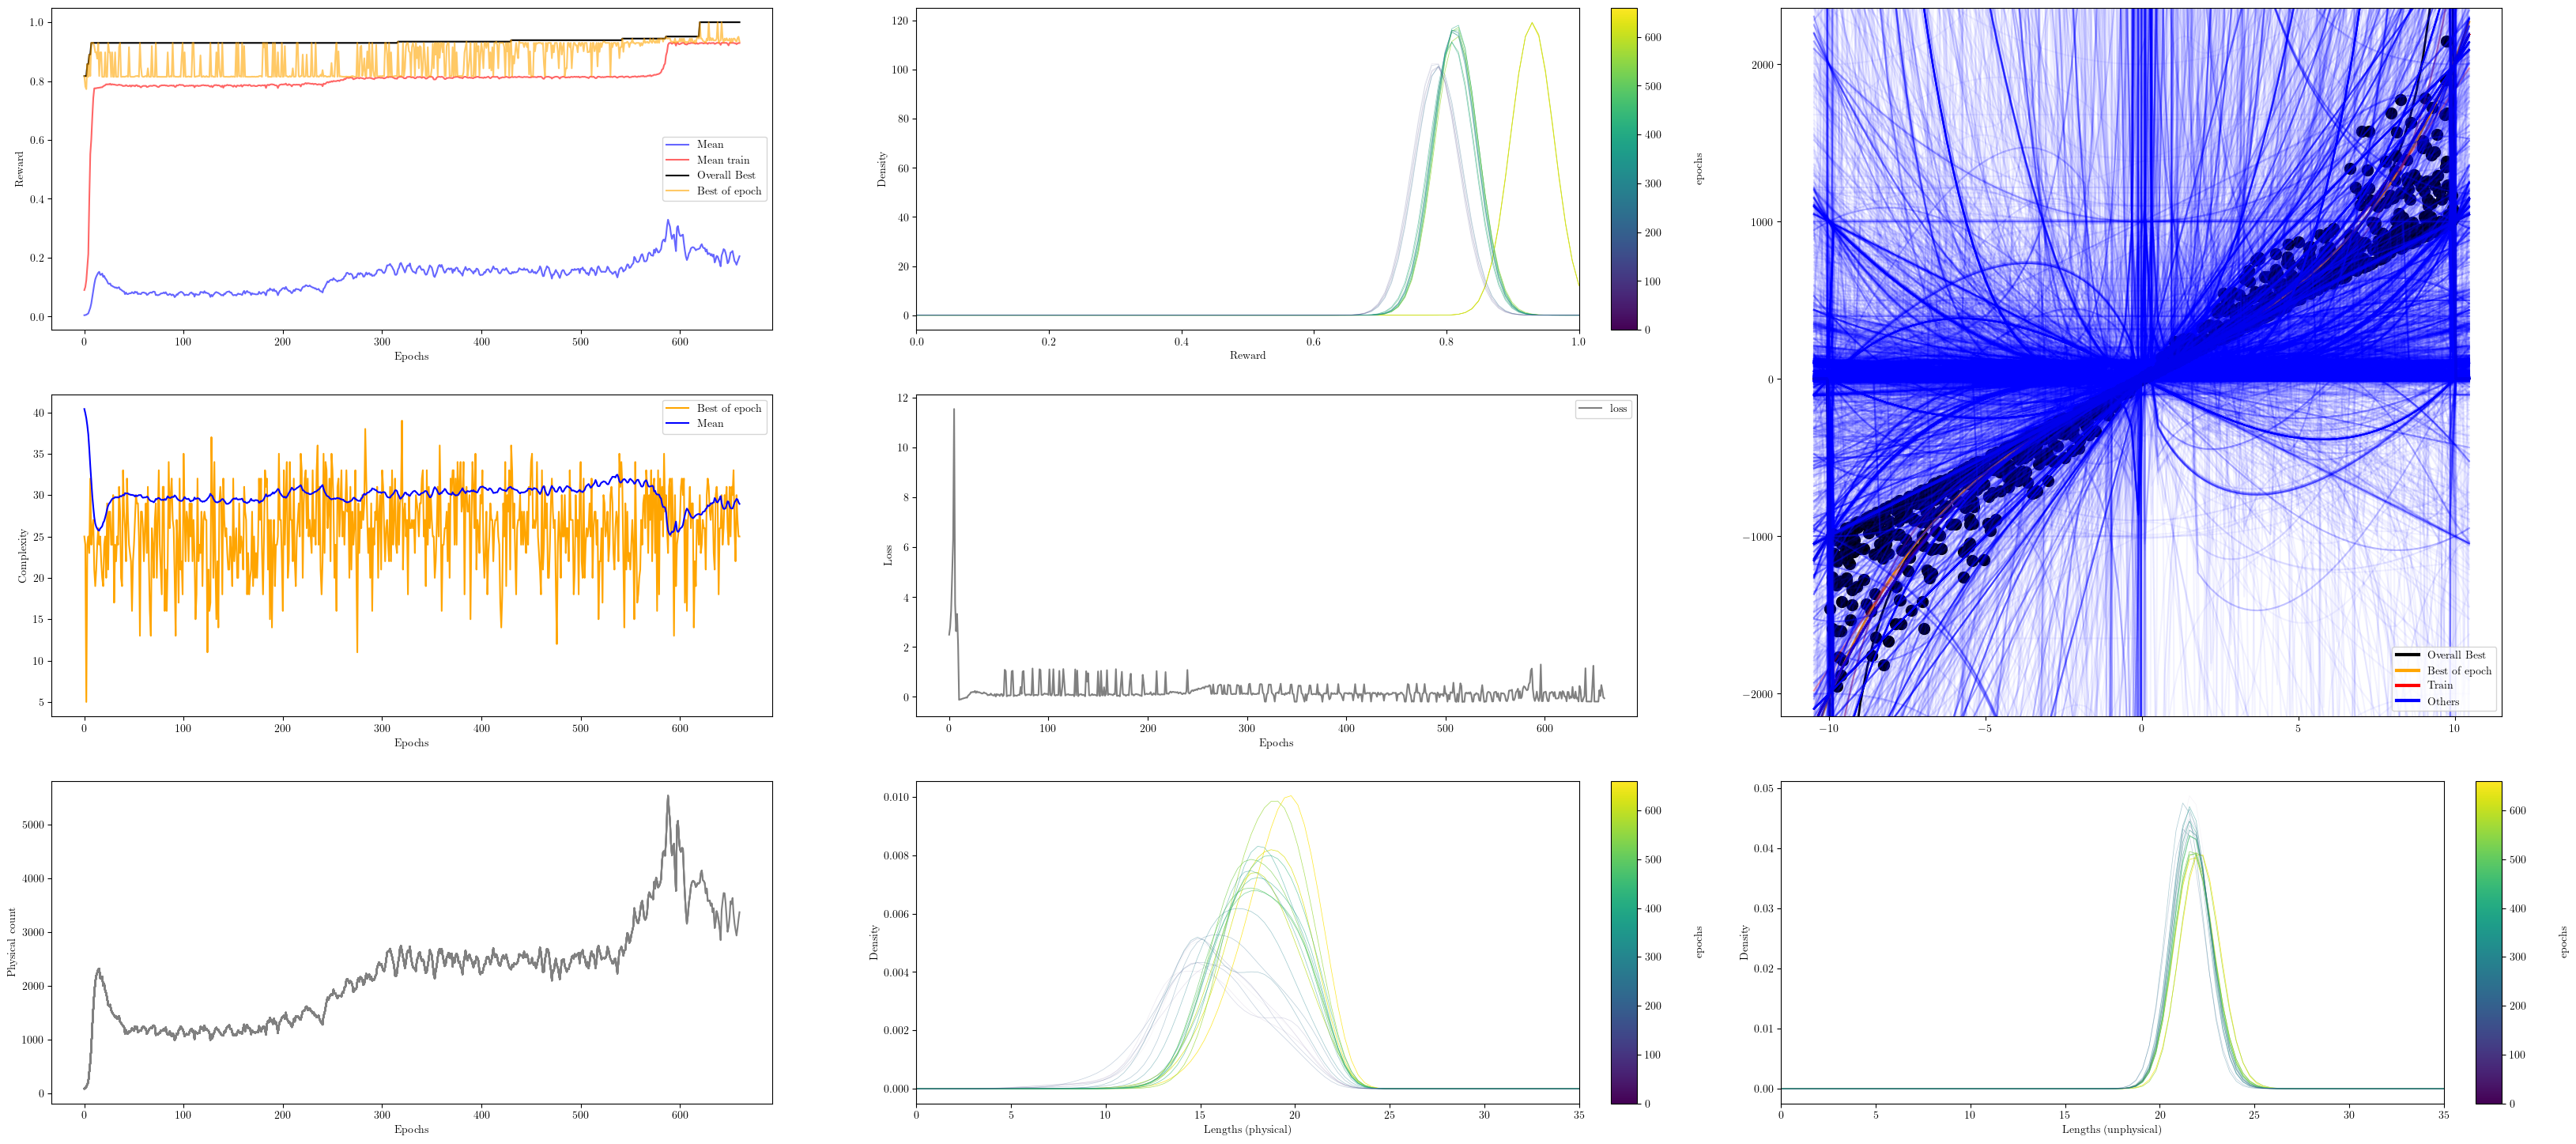

In [20]:
rewards, candidates = physo.fit(X, y, run_config)

## Results

### Run plot

/home/wassim/anaconda3/envs/PhySO/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


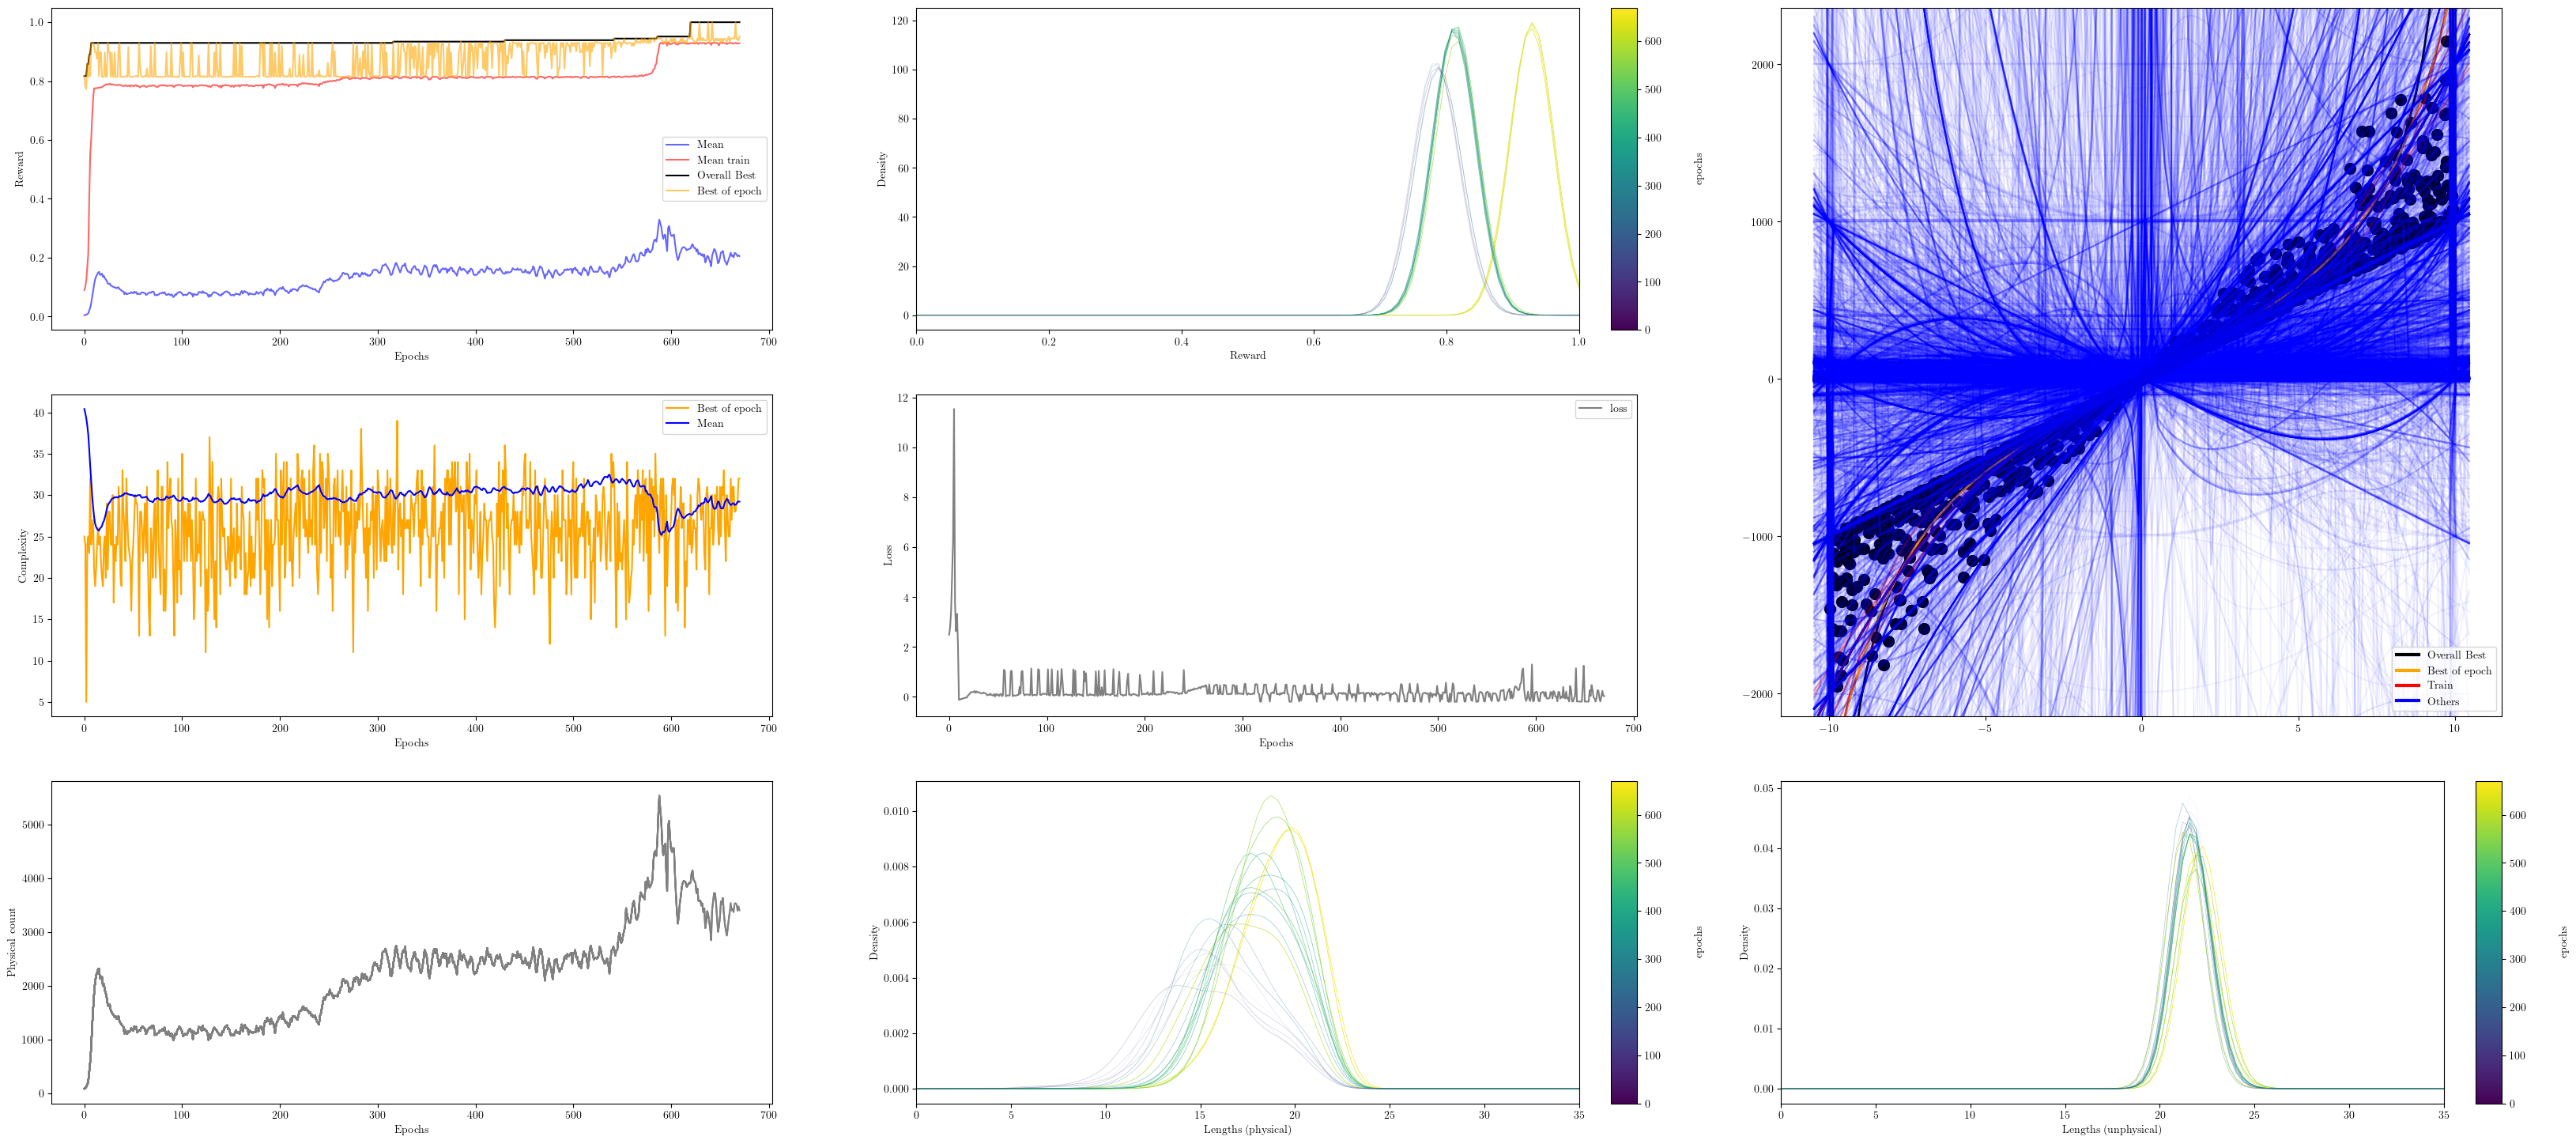

In [21]:
run_visualiser.make_visualisation()

### Pareto Front

In [22]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

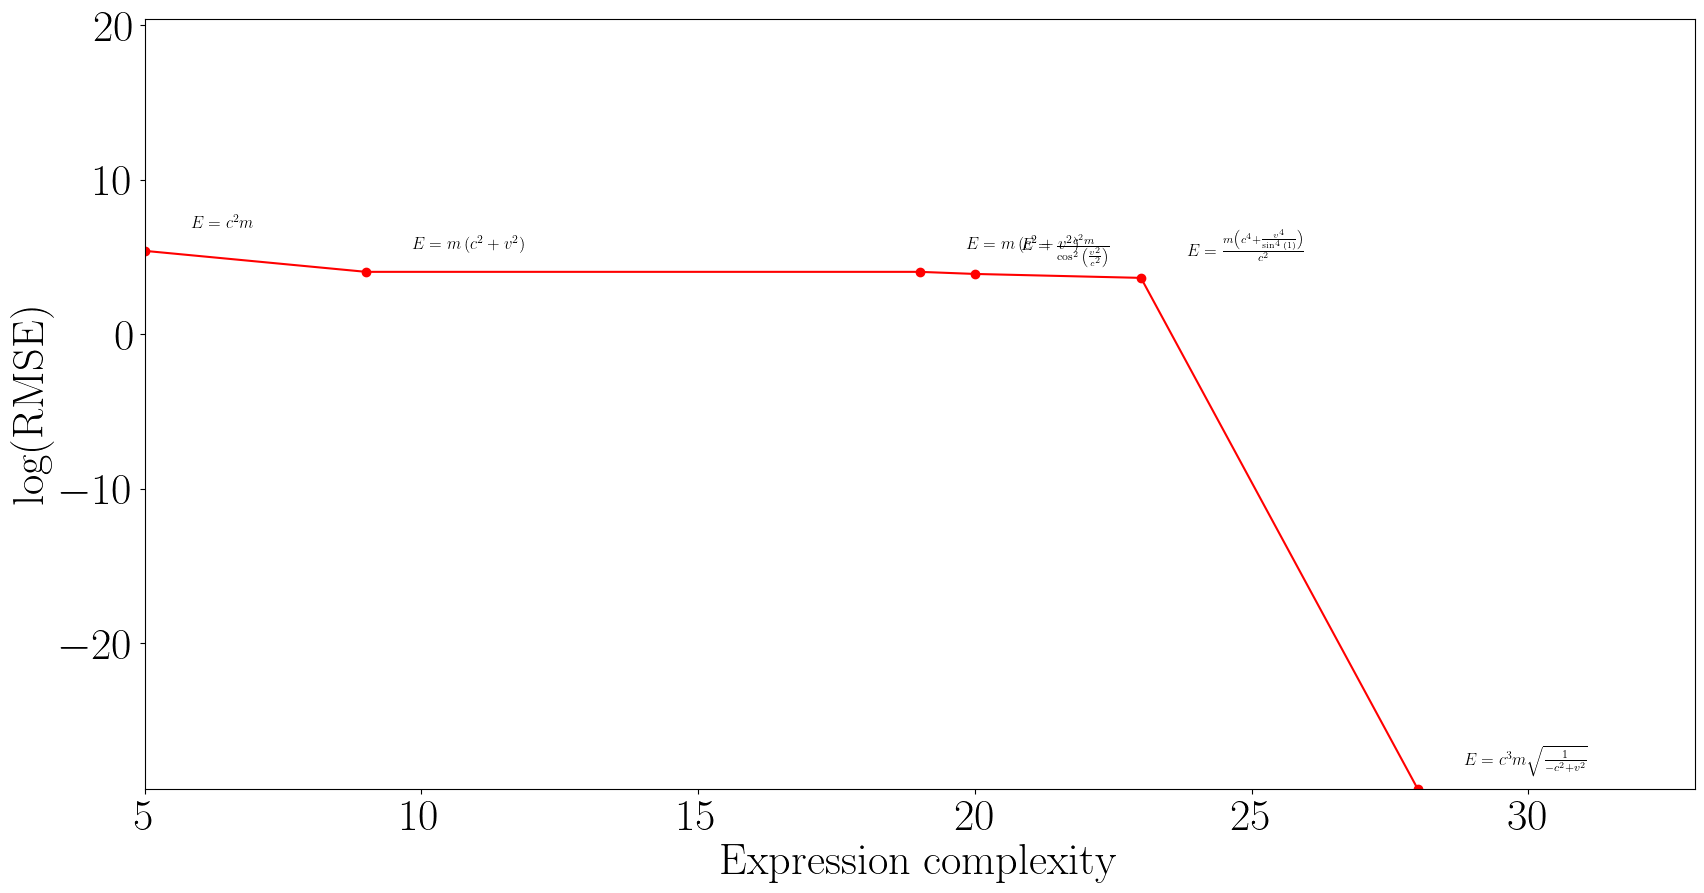

In [23]:
plot_pareto_front(run_logger)


In [24]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


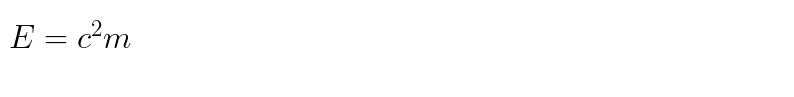

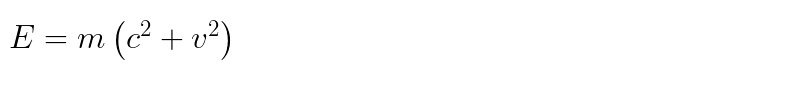

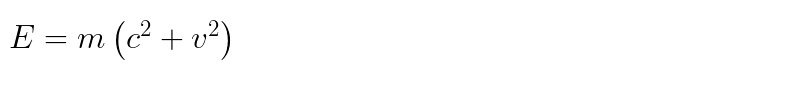

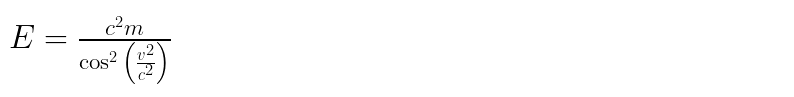

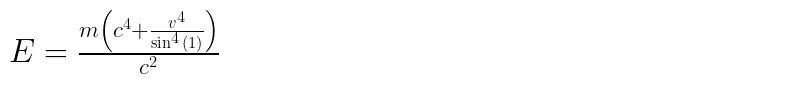

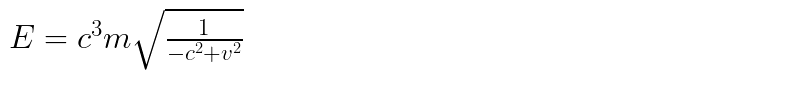

In [25]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [26]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [27]:
target_prog_sympy

c**2*m/sqrt(1 - v**2/c**2)

In [28]:
best_prog_sympy

c**3*m/sqrt(-c**2 + v**2)

In [29]:
target_prog_sympy == best_prog_sympy

False

In [30]:
hall_of_fame = run_logger.hall_of_fame

In [31]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

c**2/(1/(m*log(1/(-1*1 + sin(1)**2*1))))
m*(c/cos(c*m*v/(c*c*m)))**2
1*(c*c*m*sin(1) + 1*v*v*m)/1
c*c*m + c*v*c*v*m/(c*1*c)
exp(v**2*(sin(c/c)/c)**2)/(1/(c*c*m))
c/(((c/((c*c*m))))*sin(exp((v/((1/1/c)))**0.5)))
exp((v/((c/(sin(1)**0.5))))**2)/(1/(c*c*m))
c*c*m + ((v/sin(1))**2)**2*1*1/(c*c/m)
c/((1/(c*c*m))*((v**2 - 1/(1/(c*c)))**0.5))


In [32]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

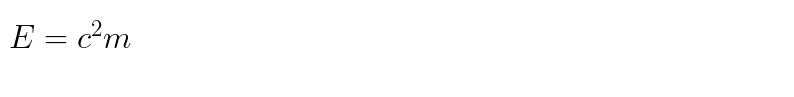

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [33]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])